In [141]:
import math
import numpy as np
from IPython.display import clear_output
import pdb
import time

import matplotlib.pyplot as plt

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable
from torchdiffeq import odeint_adjoint as odeint
from torch.distributions import MultivariateNormal
use_cuda = torch.cuda.is_available()
from geomloss import SamplesLoss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import gc
import importlib
import Utils
importlib.reload(Utils)
from Utils import InputMapping, BoundingBox, ImageDataset, SaveTrajectory
from Utils import SaveTrajectory as st
import ODEModel
importlib.reload(ODEModel)
from ODEModel import ODEfunc
from ODEModel import FfjordModel
import LearnTraj
importlib.reload(LearnTraj);
from LearnTraj import learn_trajectory


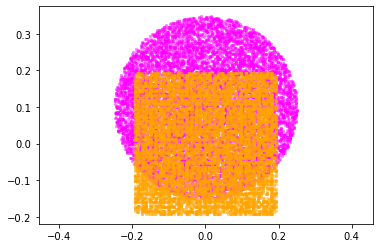

In [142]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
caterpillar = 1-ImageDataset.import_img('caterpillar.png'); caterpillar/=caterpillar.max();
butterfly = 255-ImageDataset.import_img('butterfly.jpg'); butterfly/=butterfly.max();
circle = 255-ImageDataset.import_img('circle.jpeg'); circle/=circle.max();
square = 1-ImageDataset.import_img('square.png'); square/=square.max();
dset1 = ImageDataset(img=caterpillar*1,thresh=.8); 
dset2 = ImageDataset(img=butterfly*1,thresh=.8)
dset3 = ImageDataset(img=circle*1,thresh=.8)
dset4 = ImageDataset(img=square*1,thresh=.8)

n = 10000; 
dat1 = dset1.sample(n); 
dat2 = dset2.sample(n); 
dat3 = dset3.sample(n)*.7;
dat4 = dset4.sample(n);
dat1*=-1; dat1[:,1]-=.1;
dat2*=-1; dat2[:,1]+=.5; 
dat3[:,1]+=.1;

# plt.scatter(dat1.detach().numpy()[:,0],dat1.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='green')
# plt.scatter(dat2.detach().numpy()[:,0],dat2.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='red')
plt.scatter(dat3.detach().numpy()[:,0],dat3.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='magenta')
plt.scatter(dat4.detach().numpy()[:,0],dat4.detach().numpy()[:,1],s=10, alpha=0.5, linewidths=0,c='orange')
plt.axis('equal')
plt.show() 

training with sinkhorn_large_reg
batch 0 loss tensor(2., device='cuda:0', grad_fn=<AddBackward0>)


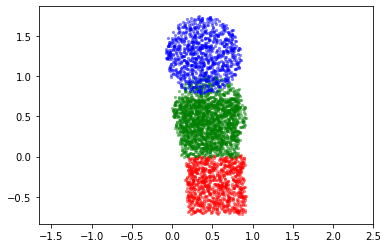

fit time  0.05909156799316406  reg loss time 0.005635976791381836
time elapsed 0.2889430522918701 total time 0.2889742851257324
batch number 0 out of 300


KeyboardInterrupt: 

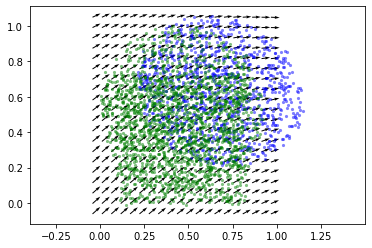

In [140]:
dat_tuple = (dat3,dat4)
z_target = torch.stack(dat_tuple).to(device)
model = FfjordModel(); 
# model.load_state('models/seq_state420_time_31.615391731262207.tar');
# model.load_state('models/state310_time_22.49951934814453.tar');
# model.load_state('models/state_start10.tar');
# for my_loss in ['sinkhorn_small_reg']:
# my_loss = 'sinkhorn_small_reg';
my_loss = 'sinkhorn_large_reg';
# %prun 
model, losses, separate_losses = learn_trajectory(z_target, my_loss=my_loss,n_iters=10000,n_subsample=1000, model=model, save=True)
st.save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=500)
st.save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=500,reverse=True)

In [ ]:
# Example with 3 timesteps
dset = ImageDataset(img=make_image())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dat = dset.sample(512)
dat2 = torch.add(dat,torch.tensor([10,-10]))
dat3 = torch.add(dat,torch.tensor([20,0]))
dat_tuple = (dat,dat2,dat3)
z_target = torch.stack(dat_tuple).to(device)

# for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg']:
for my_loss in ['sinkhorn_small_reg']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_iters=10,n_subsample=100)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)

In [ ]:
# Example with 2 timesteps
dset = ImageDataset(img=make_image())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dat = dset.sample(512)
dat2 = torch.add(dat,torch.tensor([10,-10]))

dat_tuple = (dat,dat2)
z_target = torch.stack(dat_tuple).to(device)

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg','energy_dist']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_batch=1000)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)


In [ ]:
#trying other shapes

square = np.zeros([20,20])
square[6:14,:8] = 1

two_square = np.zeros([20,20])
two_square[:5,14:] = 1
two_square[15:,14:] = 1


annulus = import_img('annulus.png')
circle = 255-import_img('circle.jpeg')

dset = ImageDataset(img=square)
dset1 = ImageDataset(img=two_square)

n = 500
dat = dset.sample(n)
dat1 = dset1.sample(n)
plt.scatter(dat.detach().numpy()[:,0],dat.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='green')
plt.scatter(dat1.detach().numpy()[:,0],dat1.detach().numpy()[:,1],s=2.3, alpha=0.1, linewidths=5,c='red')
plt.show() 

In [ ]:
# make half moon dataset
import sklearn.datasets

moons, labels = sklearn.datasets.make_moons(n,noise=.1) #generates two half moons
mask = (labels == 0)
one_moon = moons[mask,:] # only keep one moon

def rot_mat(theta0):
    #computes rotation matrix of angle theta
    return np.array([[np.cos(theta0),-np.sin(theta0)],[np.sin(theta0),np.cos(theta0)]])

theta0 = np.pi/2
theta1 = np.pi

rot0 = rot_mat(theta0)
rot1 = rot_mat(theta1)

# apply rotation to the moon
one_moon_rot0 = np.dot(one_moon,rot0)
one_moon_rot1 = np.dot(one_moon,rot1)

In [ ]:
#visualize rotated moons

plt.scatter(one_moon[:,0],one_moon[:,1], color='blue')
plt.scatter(one_moon_rot0[:,0],one_moon_rot0[:,1], color='orange')
plt.scatter(one_moon_rot1[:,0],one_moon_rot1[:,1], color='green')

In [ ]:
# with three timesteps

dat = torch.tensor(one_moon,dtype=torch.float)
dat0 = torch.tensor(one_moon_rot0,dtype=torch.float)
dat1 = torch.tensor(one_moon_rot1,dtype=torch.float)

dat_tuple = (dat,dat0,dat1)
z_target = torch.stack(dat_tuple).to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg','energy_dist']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_batch=500)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)


In [ ]:
# with two timesteps


dat_tuple = (dat,dat0)
z_target = torch.stack(dat_tuple).to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for my_loss in ['sinkhorn_large_reg','sinkhorn_small_reg','energy_dist']:
    model = learn_trajectory(z_target, my_loss=my_loss,n_batch=500)
    save_trajectory(model,z_target,my_loss, savedir='imgs', nsteps=101, memory=0.01, n=1000)
    trajectory_to_video(my_loss)


<class 'torch.Tensor'> torch.Size([256, 2])
torch.Size([2])
torch.Size([0])


ValueError: x and y must have same first dimension, but have shapes (0,) and (2,)

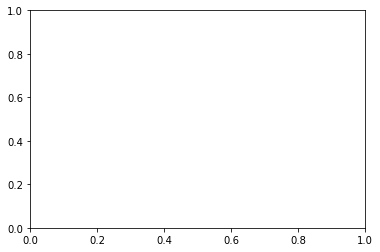

In [61]:
# test what weights are given to what frequencies
for param in model.parameters():
    print(type(param.data), param.size())
    pdat = param.data;
    break;    
pmags = torch.norm(param.data,p=2,dim=0);
print(pmags[0:200].size())

freqs = model.time_deriv_func.imap.B;
fmags = torch.norm(freqs,p=2,dim=1);
xyfreqs = torch.cat([fmags, fmags],dim=0);
print(xyfreqs.size())

# xyfreqs.cpu().numpy()
plt.plot(xyfreqs.cpu().numpy(), pmags[0:200].cpu().numpy(),'.')
plt.plot([0, 0], pmags[200:202].cpu().numpy(),'.')
# freqs
# fmags

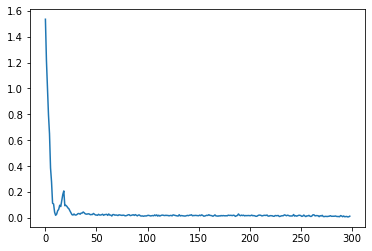

In [135]:
plt.plot(losses[1:]); 
# plt.plot(separate_losses[0,1:]); 
# plt.plot(separate_losses[1,1:]); 
# plt.plot(separate_losses[2,50:]); 
# plt.plot(separate_losses[3,50:]); 
# plt.plot(separate_losses[4,50:]); 
# plt.plot(separate_losses[5,50:]); 
# plt.plot(separate_losses[6,0:]);
plt.show()

In [ ]:
losses